## Introduction to Bayesian Power Analysis: Exclude a Null Value

Recently, I have been thinking a lot about data-driven decision making. In particular, in the context of experimentation. Why? Well, I have to be honest, I do not feel comfortable (at all!) with the common practice of using p-values and null hypothesis significance testing to make decisions. I simply don't feel confident about the approach. I often think is because I simply do not get it, I really need to think about it when I am fore to precisely define a confidence interval.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import preliz as pz
import pymc as pm
from pymc.util import RandomState
from tqdm.notebook import tqdm

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "power_sample_size"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

<Axes: >

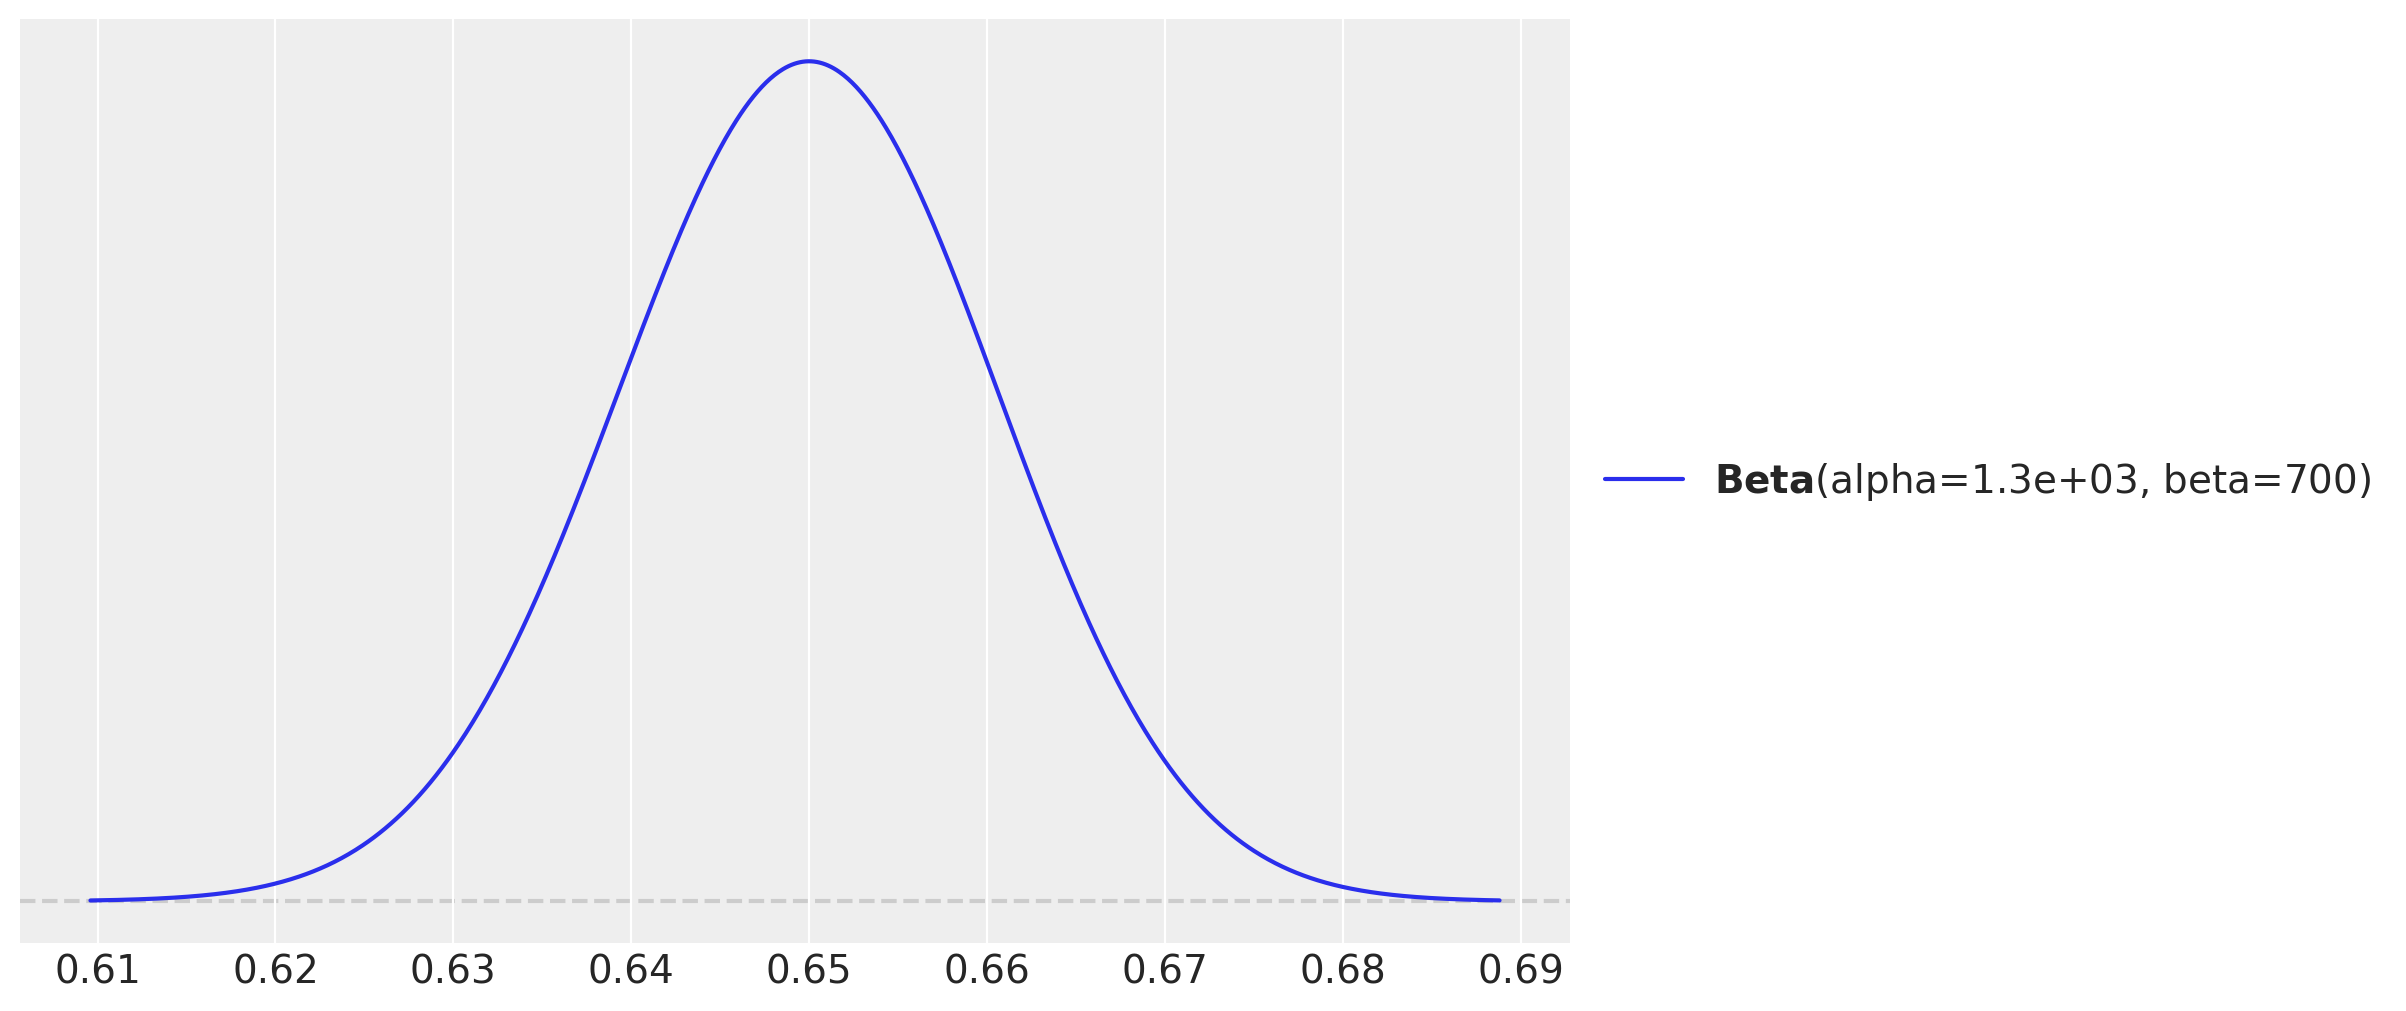

In [3]:
fig, ax = plt.subplots()
omega = 0.65
pz.Beta(alpha=omega * (2_000 - 2) + 1, beta=(1 - omega) * (2_000 - 2) + 1).plot_pdf(
    ax=ax
)


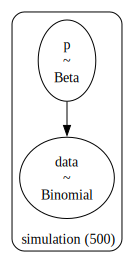

In [4]:
n_simulations = 500
n = 150

with pm.Model(coords={"simulation": range(n_simulations)}) as data_generating_model:
    omega = 0.65
    p = pm.Beta(
        "p",
        alpha=omega * (2_000 - 2) + 1,
        beta=(1 - omega) * (2_000 - 2) + 1,
        dims="simulation",
    )
    pm.Binomial("data", n=n, p=p, dims=("simulation",))

pm.model_to_graphviz(data_generating_model)


In [5]:
with data_generating_model:
    generating_model_idata = pm.sample_prior_predictive(samples=1, random_seed=rng)

generated_data = generating_model_idata["prior"]["data"].sel(chain=0, draw=0).to_numpy()

generated_data


Sampling: [data, p]


array([101,  90,  96,  96, 101,  97, 106,  98,  96, 100, 101,  94, 102,
       104,  93,  88, 113,  89,  95,  94,  88,  90,  96,  93, 101,  93,
        99,  89, 103,  98,  90,  99,  92,  93,  83,  94, 107,  91,  93,
       105,  96, 102, 102,  93,  93,  86,  93,  96, 102, 104,  90,  92,
       103, 107, 102,  90,  95, 107,  92, 102,  97,  99, 106,  98,  99,
        94, 100,  83,  99, 100, 108,  97, 108,  99,  93, 103,  99,  92,
        98, 113,  98,  96, 105,  87, 103,  96, 105,  91, 105,  94,  89,
        98,  96,  91,  99,  98,  96, 101,  91,  94,  92,  92,  94,  97,
       102, 108,  92,  95,  99,  85,  99,  99, 100,  94, 105,  95,  97,
        98,  86, 104, 101, 104,  98, 104, 101, 102,  94, 102, 102, 106,
       104,  96,  99,  98,  92, 104,  94,  92,  85,  96,  93,  88, 112,
        94, 110, 102, 102,  96,  90,  88,  91, 103, 100,  88, 102, 103,
        97,  90,  80,  93,  91,  93, 102,  96, 101,  97,  98, 101, 100,
        98,  94, 105,  95, 102, 105, 104, 100,  96,  91,  92,  9

<Axes: >

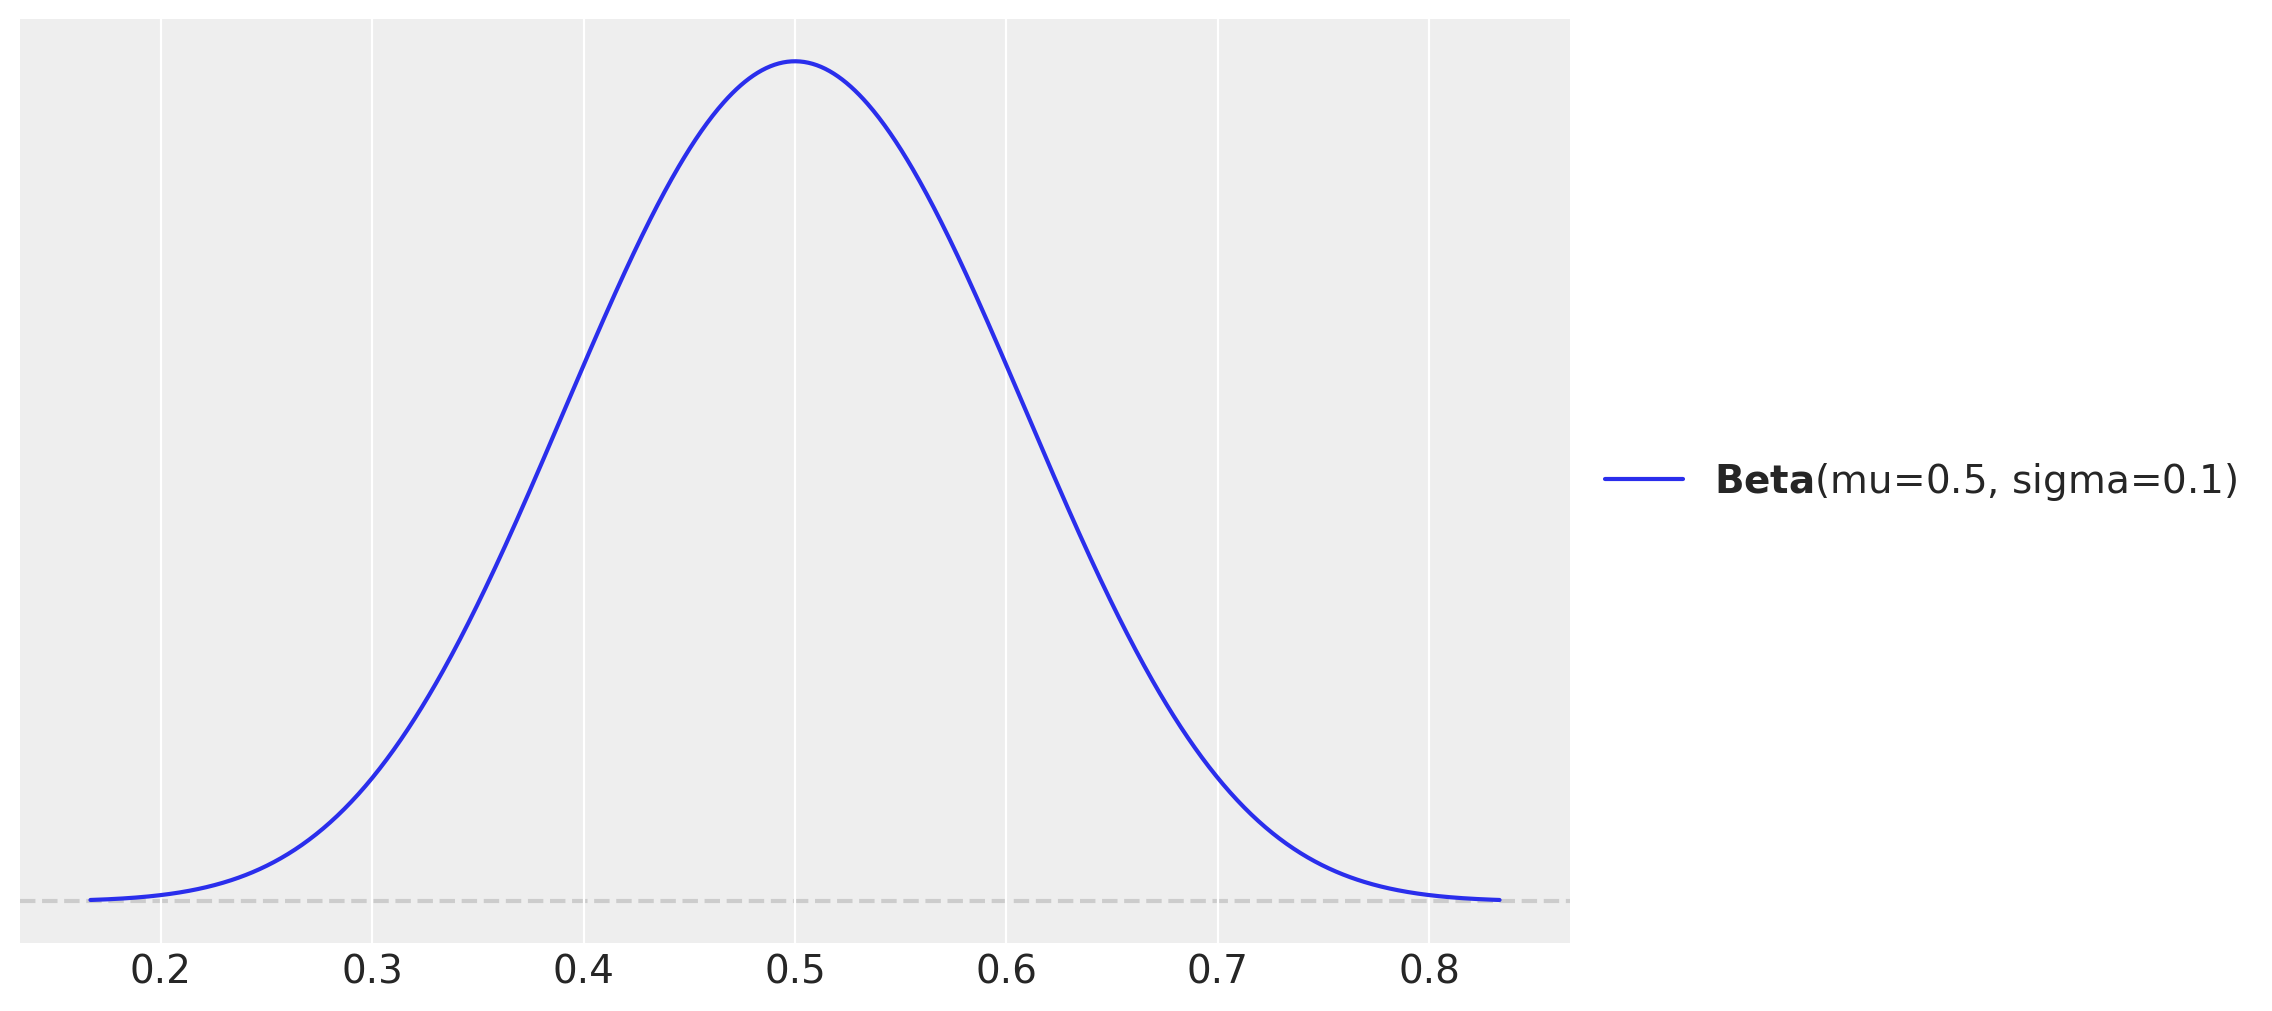

In [6]:
fig, ax = plt.subplots()
pz.Beta(mu=0.5, sigma=0.1).plot_pdf(ax=ax)

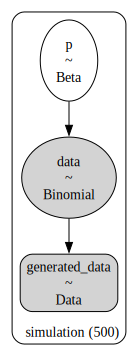

In [7]:
with pm.Model(coords={"simulation": range(n_simulations)}) as model:
    generated_data_ = pm.Data("generated_data", generated_data, dims=("simulation",))
    p = pm.Beta("p", mu=0.5, sigma=0.1, dims="simulation")
    pm.Binomial("data", n=n, p=p, observed=generated_data_, dims=("simulation",))

pm.model_to_graphviz(model)

In [8]:
with model:
    idata = pm.sample(random_seed=rng)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [9]:
az.summary(idata["posterior"].sel(simulation=slice(None, 10)), var_names=["p"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.649,0.036,0.585,0.719,0.0,0.001,11586.0,2634.0,1.0
p[1],0.586,0.037,0.522,0.661,0.0,0.001,13071.0,2890.0,1.0
p[2],0.621,0.037,0.553,0.690,0.0,0.001,10630.0,2772.0,1.0
p[3],0.621,0.037,0.552,0.690,0.0,0.001,9460.0,2550.0,1.0
p[4],0.650,0.038,0.581,0.720,0.0,0.001,8358.0,2381.0,1.0
p[5],0.627,0.037,0.553,0.692,0.0,0.001,9505.0,2328.0,1.0
p[6],0.678,0.035,0.611,0.742,0.0,0.001,10125.0,2841.0,1.0
p[7],0.632,0.036,0.566,0.701,0.0,0.001,10597.0,2833.0,1.0
p[8],0.621,0.036,0.554,0.689,0.0,0.001,12590.0,2577.0,1.0
p[9],0.644,0.035,0.580,0.712,0.0,0.001,10177.0,2606.0,1.0


array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

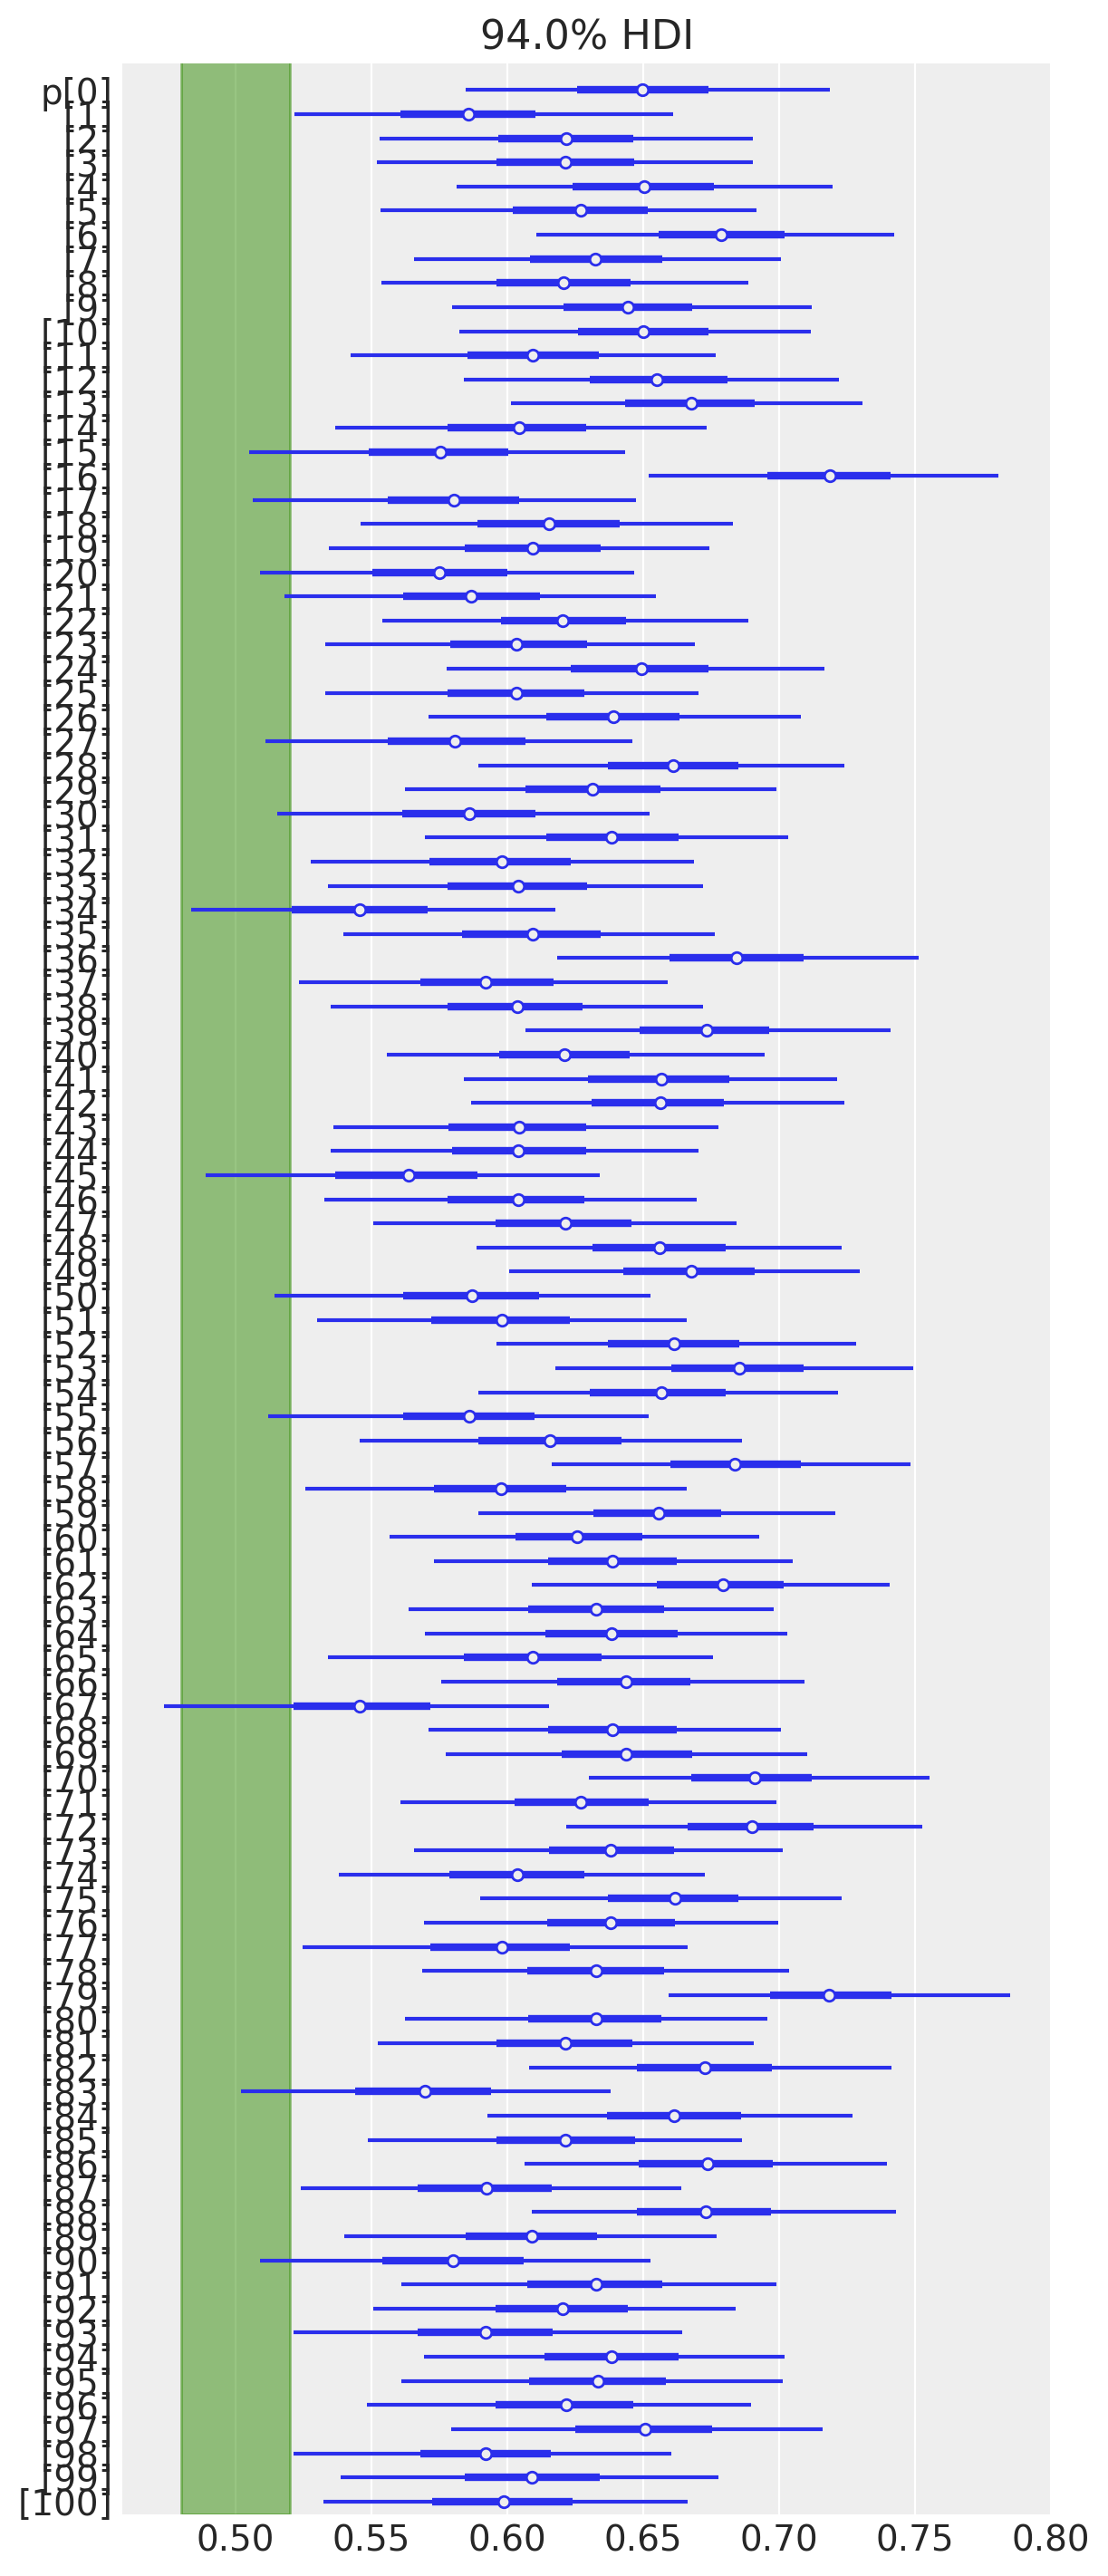

In [10]:
az.plot_forest(
    idata["posterior"].sel(simulation=slice(None, 100)),
    var_names=["p"],
    combined=True,
    rope=[0.48, 0.52],
)

In [11]:
hdi = az.hdi(idata["posterior"], hdi_prob=0.94)["p"]

rope = (0.48, 0.52)

((hdi.sel(hdi="lower") > rope[1]) | (hdi.sel(hdi="higher") < rope[0])).mean().item()

0.868

In [12]:
def generate_data(
    n_simulations: int, n: int, omega: float, random_seed: RandomState
) -> npt.NDArray:
    with pm.Model(coords={"simulation": range(n_simulations)}):
        p = pm.Beta(
            "p",
            alpha=omega * (2_000 - 2) + 1,
            beta=(1 - omega) * (2_000 - 2) + 1,
            dims="simulation",
        )
        pm.Binomial("data", n=n, p=p, dims=("simulation",))

        generating_model_idata = pm.sample_prior_predictive(
            samples=1, random_seed=random_seed
        )

    return generating_model_idata["prior"]["data"].sel(chain=0, draw=0).to_numpy()


def fit_model(
    generated_data: npt.NDArray, n_simulations: int, n: int, random_seed: RandomState
) -> az.InferenceData:
    with pm.Model(coords={"simulation": range(n_simulations)}):
        generated_data_ = pm.Data(
            "generated_data", generated_data, dims=("simulation",)
        )
        p = pm.Beta("p", mu=0.5, sigma=0.1, dims="simulation")
        pm.Binomial("data", n=n, p=p, observed=generated_data_, dims=("simulation",))

        idata = pm.sample(random_seed=random_seed, progressbar=False)
    return idata


def calculate_power(
    idata: az.InferenceData, hdi_prob: float, rope: tuple[int, int]
) -> float:
    hdi = az.hdi(idata["posterior"], hdi_prob=hdi_prob)["p"]
    condition = (hdi.sel(hdi="lower") > rope[1]) | (hdi.sel(hdi="higher") < rope[0])
    return condition.mean().item()


In [13]:
omega = 0.65
n_simulations = 500
n = 150
rope = (0.48, 0.52)
hdi_prob = 0.94


def run_power_analysis(
    n_simulations: int,
    n: int,
    omega: float,
    rope: tuple[int, int],
    hdi_prob: float,
    random_seed: RandomState,
):
    generated_data = generate_data(
        n_simulations=n_simulations, n=n, omega=omega, random_seed=random_seed
    )
    idata = fit_model(
        generated_data, n_simulations=n_simulations, n=n, random_seed=random_seed
    )
    return calculate_power(idata, hdi_prob=hdi_prob, rope=rope)


run_power_analysis(
    n_simulations=n_simulations,
    n=n,
    omega=omega,
    rope=rope,
    hdi_prob=hdi_prob,
    random_seed=rng,
)


Sampling: [data, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


0.872

In [14]:
%%time

n_simulations = 500
rope = (0.48, 0.52)
hdi_prob = 0.94
omegas = np.linspace(0.5, 0.85, 8)
sample_sizes = np.linspace(10, 500, 20, dtype=int)

results = {}
results = {omega: [] for omega in omegas}

param_combinations = [
    (omega, sample_size) for omega in omegas for sample_size in sample_sizes
]

for omega, sample_size in tqdm(param_combinations, desc="Running power analysis"):
    power = run_power_analysis(
        n_simulations=n_simulations,
        n=sample_size,
        omega=omega,
        rope=rope,
        hdi_prob=hdi_prob,
        random_seed=rng,
    )
    results[omega].append(power)


Running power analysis:   0%|          | 0/120 [00:00<?, ?it/s]

Sampling: [data, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [data, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [data, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [data, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [data, p]
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p

CPU times: user 2min 24s, sys: 15 s, total: 2min 39s
Wall time: 4min 55s


[Text(0.5, 1.0, 'Power analysis for different sample sizes'),
 Text(0.5, 0, 'sample size'),
 Text(0, 0.5, 'power')]

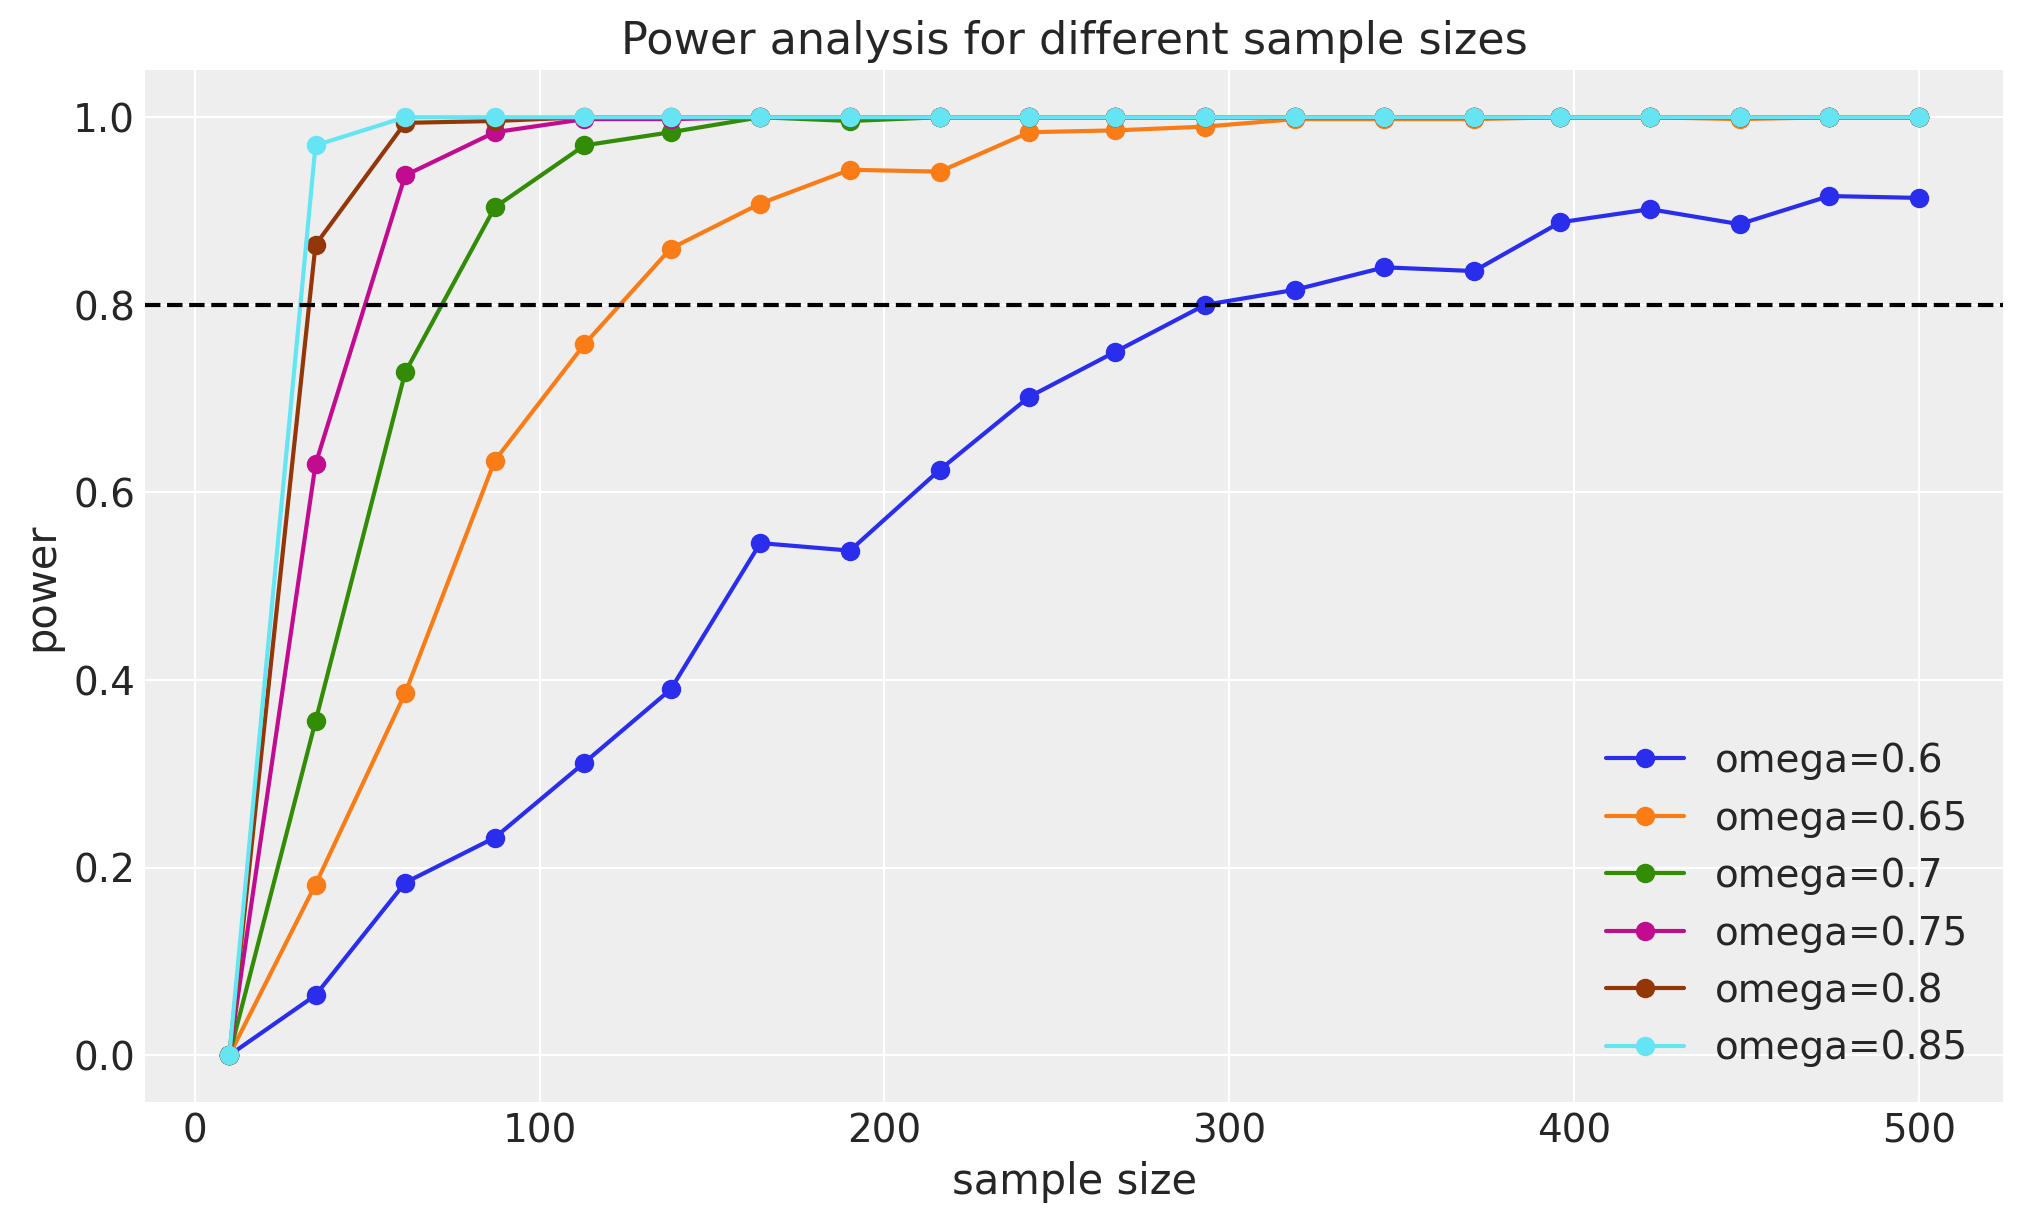

In [15]:
fig, ax = plt.subplots()

for i, omega in enumerate(omegas):
    ax.plot(sample_sizes, results[omega], marker="o", c=f"C{i}", label=f"omega={omega}")


ax.axhline(0.8, c="black", ls="--")
ax.legend()
ax.set(
    title="Power analysis for different sample sizes",
    xlabel="sample size",
    ylabel="power",
)

<Axes: ylabel='sample_size'>

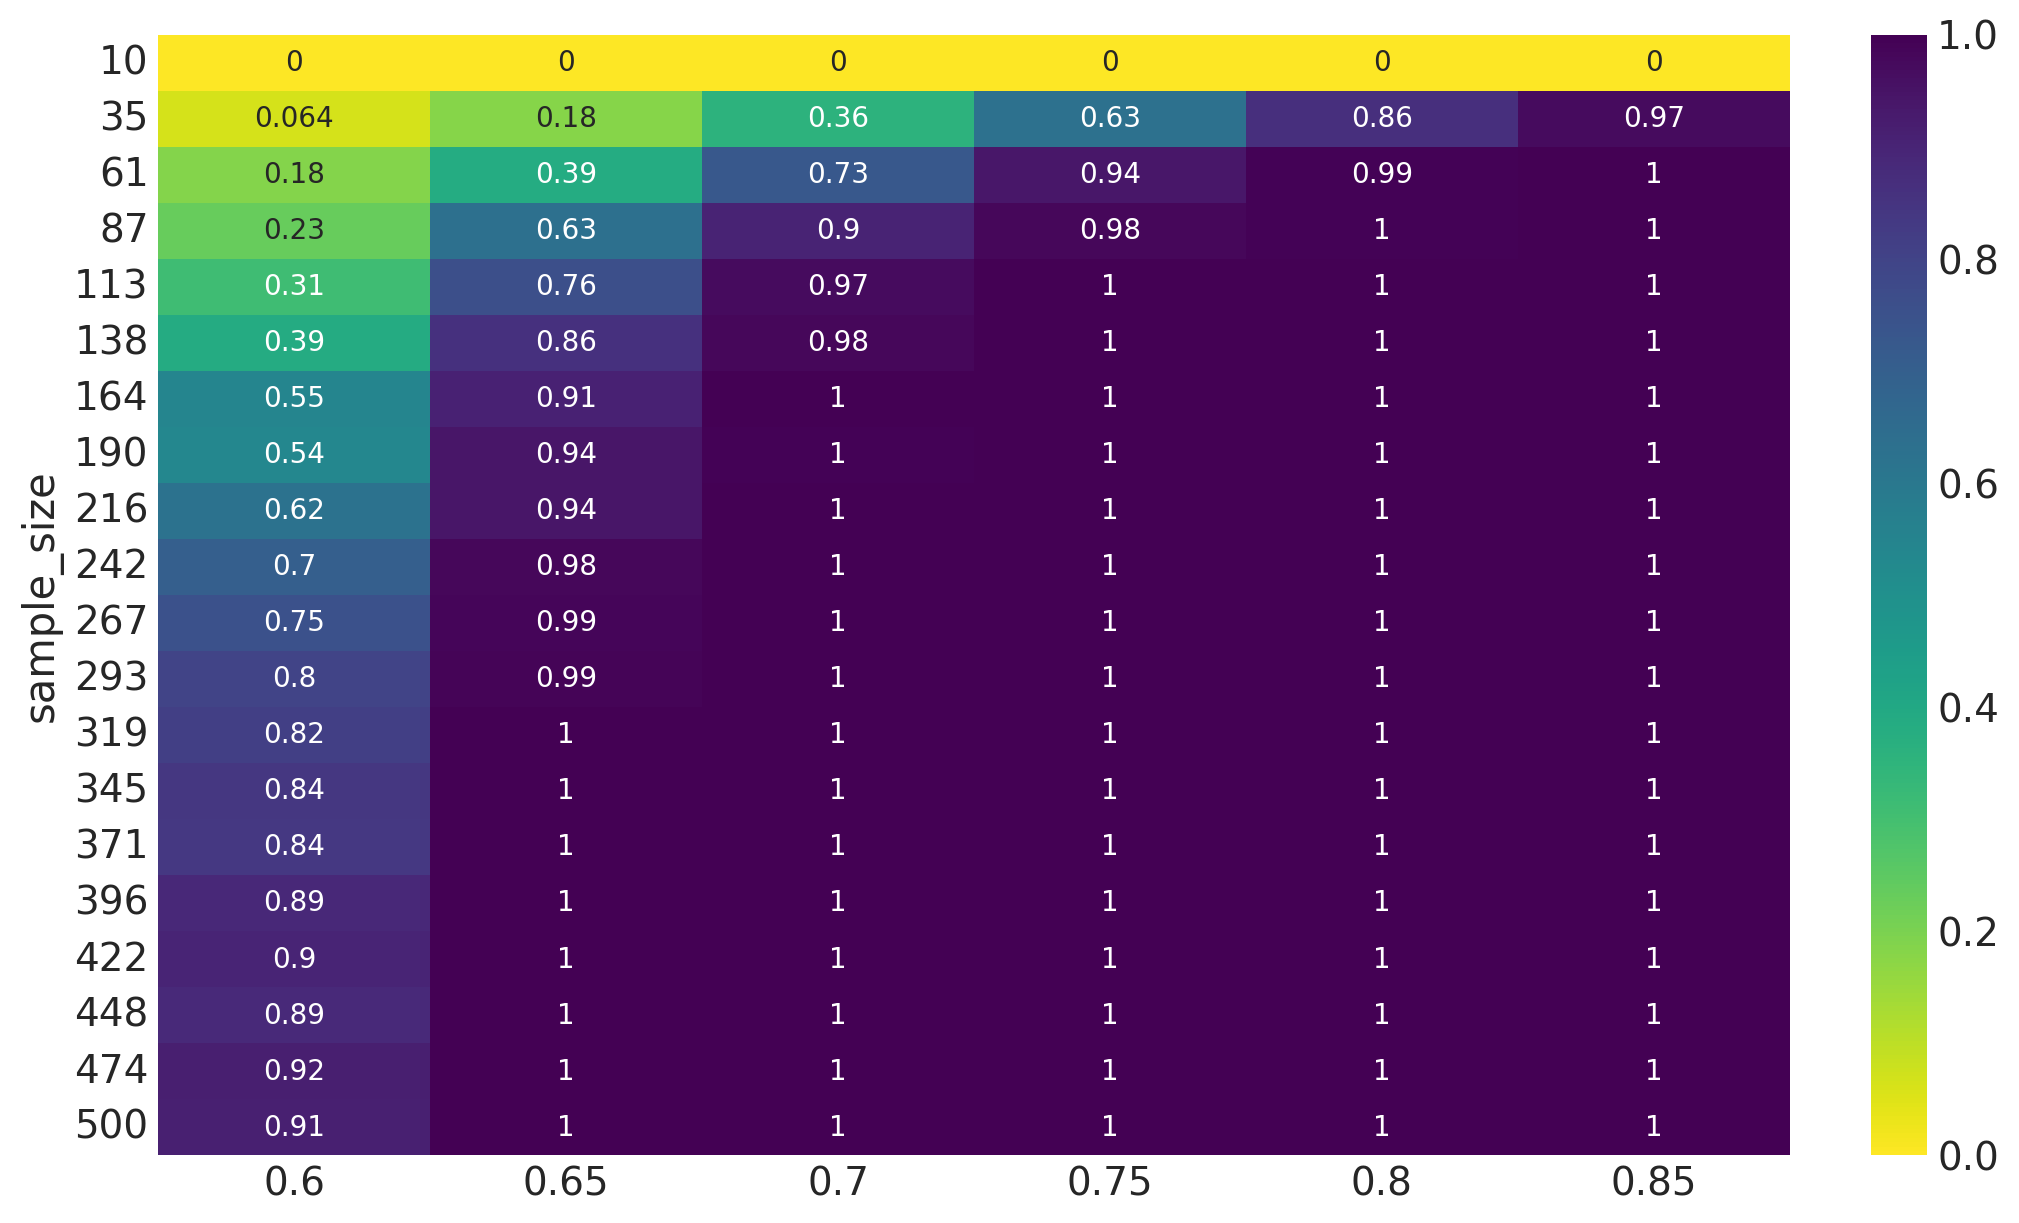

In [32]:
import pandas as pd
import seaborn as sns

results_df = pd.DataFrame({"sample_size": sample_sizes, **results}).set_index(
    "sample_size"
)


sns.heatmap(
    data=results_df,
    annot=True,
    cmap="viridis_r",
)